# P03_01_Univar_ARIMA_AR

In [1]:
section_fig_main_title = 'P03_01_Univar_ARIMA_AR'

In [55]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot
import json

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [6]:
# !/Users/amin/anaconda3/bin/python -m pip install pmdarima
# !/Users/amin/anaconda3/bin/python -m pip install statsmodels

In [7]:
from pandas.plotting import autocorrelation_plot
import gif
from sklearn.metrics import r2_score


In [8]:
# !pip install statsmodels --upgrade
# !/Users/amin/anaconda3/bin/python -m pip install statsmodels --upgrade

In [9]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [10]:
import tensorflow as tf
tf.__version__

import tensorflow as tf
from tensorflow import keras

import gif
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/amin/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [11]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data 

Using the original data without any feature engineering.

In [12]:
csv_path = "../Data/Data_ICME_Edited_Decoded_out_P02_03.csv"
df = pd.read_csv(csv_path, parse_dates=True, infer_datetime_format=True)

In [13]:
df.head(2)

ICME Plasma/Field Start Y/M/D (UT) (b) ICME Plasma/Field End Y/M/D (UT) (b)  \
0                    1996-05-27 15:00:00                  1996-05-29 03:00:00   
1                    1996-07-01 18:00:00                  1996-07-02 11:00:00   

   BDE? (e)  Qual. (g)  dV (km/s) (h)  V_ICME (km/s) (i)  V_max (km/s) (j)  \
0         1          2              1                370               400   
1         1          4             44                360               370   

   B (nT) (k)  MC? (l)  Dst (nT) (m)  Normalized_time_interval  
0           9        3           117                  1.375000  
1          11        3            78                  0.583333

drop ICME start and end columns and make start ICME as index.

In [14]:

df['ICME Plasma/Field Start Y/M/D (UT) (b)'] = pd.to_datetime(df['ICME Plasma/Field Start Y/M/D (UT) (b)'])
df['ICME Plasma/Field End Y/M/D (UT) (b)'] = pd.to_datetime(df['ICME Plasma/Field End Y/M/D (UT) (b)'])

In [15]:
df.index = df['ICME Plasma/Field Start Y/M/D (UT) (b)']
df = df.drop(columns=['ICME Plasma/Field Start Y/M/D (UT) (b)'])
df = df.drop(columns=['ICME Plasma/Field End Y/M/D (UT) (b)'])
# df.head()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 1996-05-27 15:00:00 to 2021-05-12 15:00:00
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BDE? (e)                  493 non-null    int64  
 1   Qual. (g)                 493 non-null    int64  
 2   dV (km/s) (h)             493 non-null    int64  
 3   V_ICME (km/s) (i)         493 non-null    int64  
 4   V_max (km/s) (j)          493 non-null    int64  
 5   B (nT) (k)                493 non-null    int64  
 6   MC? (l)                   493 non-null    int64  
 7   Dst (nT) (m)              493 non-null    int64  
 8   Normalized_time_interval  493 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 38.5 KB


## Goal

The goal is to predict the ICME speed taking the last 60 timestamps into account.

In [17]:
plt.rcParams["figure.figsize"] = (8, 8)


In [18]:
ICME_speed = pd.Series(df['V_ICME (km/s) (i)'])
ICME_speed.head()

ICME Plasma/Field Start Y/M/D (UT) (b)
1996-05-27 15:00:00    370
1996-07-01 18:00:00    360
1996-08-07 12:00:00    350
1996-12-23 17:00:00    360
1997-01-10 04:00:00    450
Name: V_ICME (km/s) (i), dtype: int64

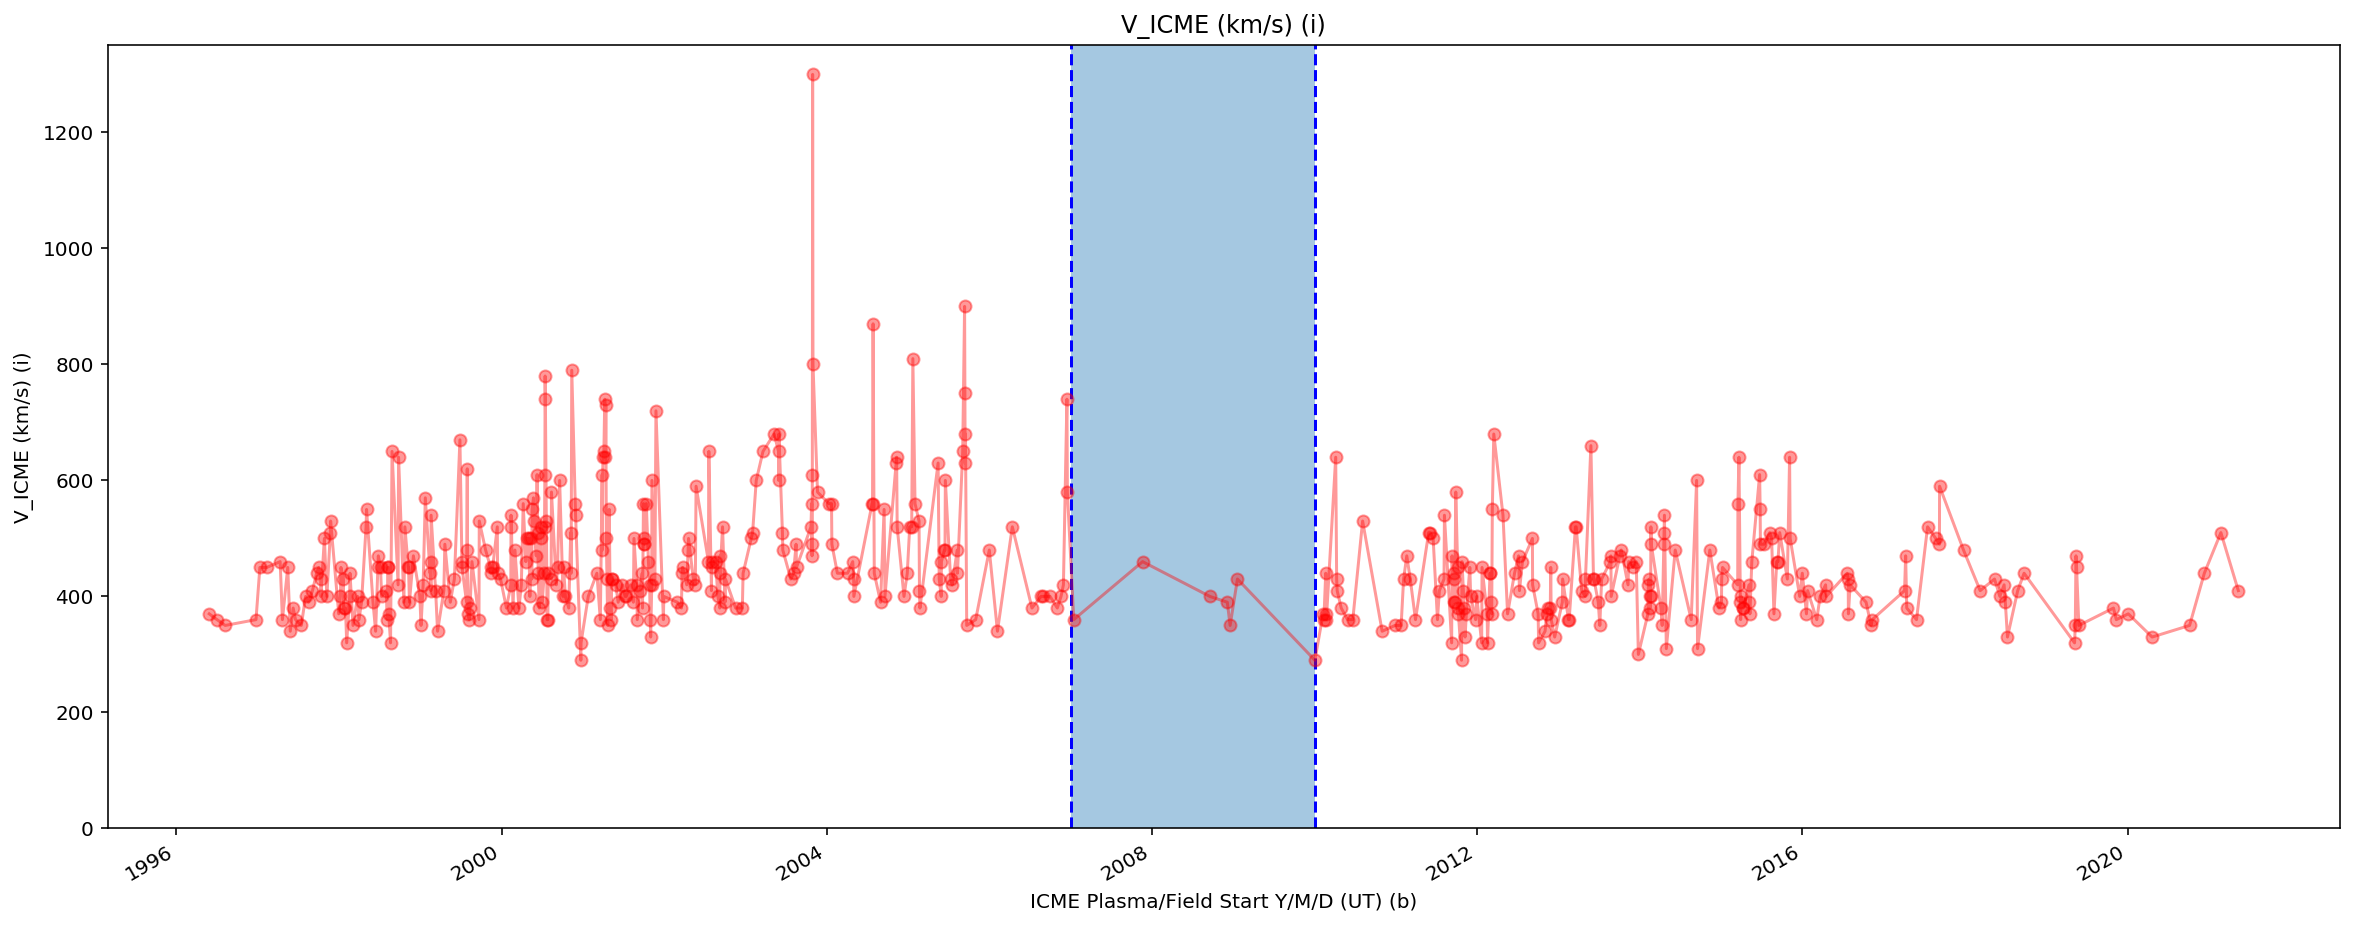

In [19]:
plt.figure(figsize=(20,8))
ICME_speed.plot(style="ro-", alpha=0.4)


plt.title("V_ICME (km/s) (i)")
plt.ylabel("V_ICME (km/s) (i)")
plt.ylim(0,)


plt.vlines('2007', 0, 1400, colors='b', linestyles='--')
plt.vlines('2010', 0, 1400, colors='b', linestyles='--')


x = ['2007', '2007', '2010', '2010']
y = [0, 1400, 1400, 0]

plt.fill_between(x, y, alpha=0.4)



plt.savefig("../Figures/" + section_fig_main_title +"ICME_speed.png")

plt.show()

In [20]:
type(ICME_speed)

pandas.core.series.Series

calculate the time interval differences and normalize it by mean.

In [21]:
time_interval_diff = ICME_speed.index.to_series().diff()

In [22]:
mean_val = np.mean(time_interval_diff)
mean_val

Timedelta('18 days 12:40:58.536585365')

the data in average recorded each 18 days. That means if we assume that the data timestamps are 18 days, if we apply short term forcasting using calssical models such as AR and ARIMA, they would be able to forcast the ICME speed for next 18 days.

In [23]:
time_interval_diff_norm = time_interval_diff/mean_val
time_interval_diff_norm[1]

1.8957327775340072

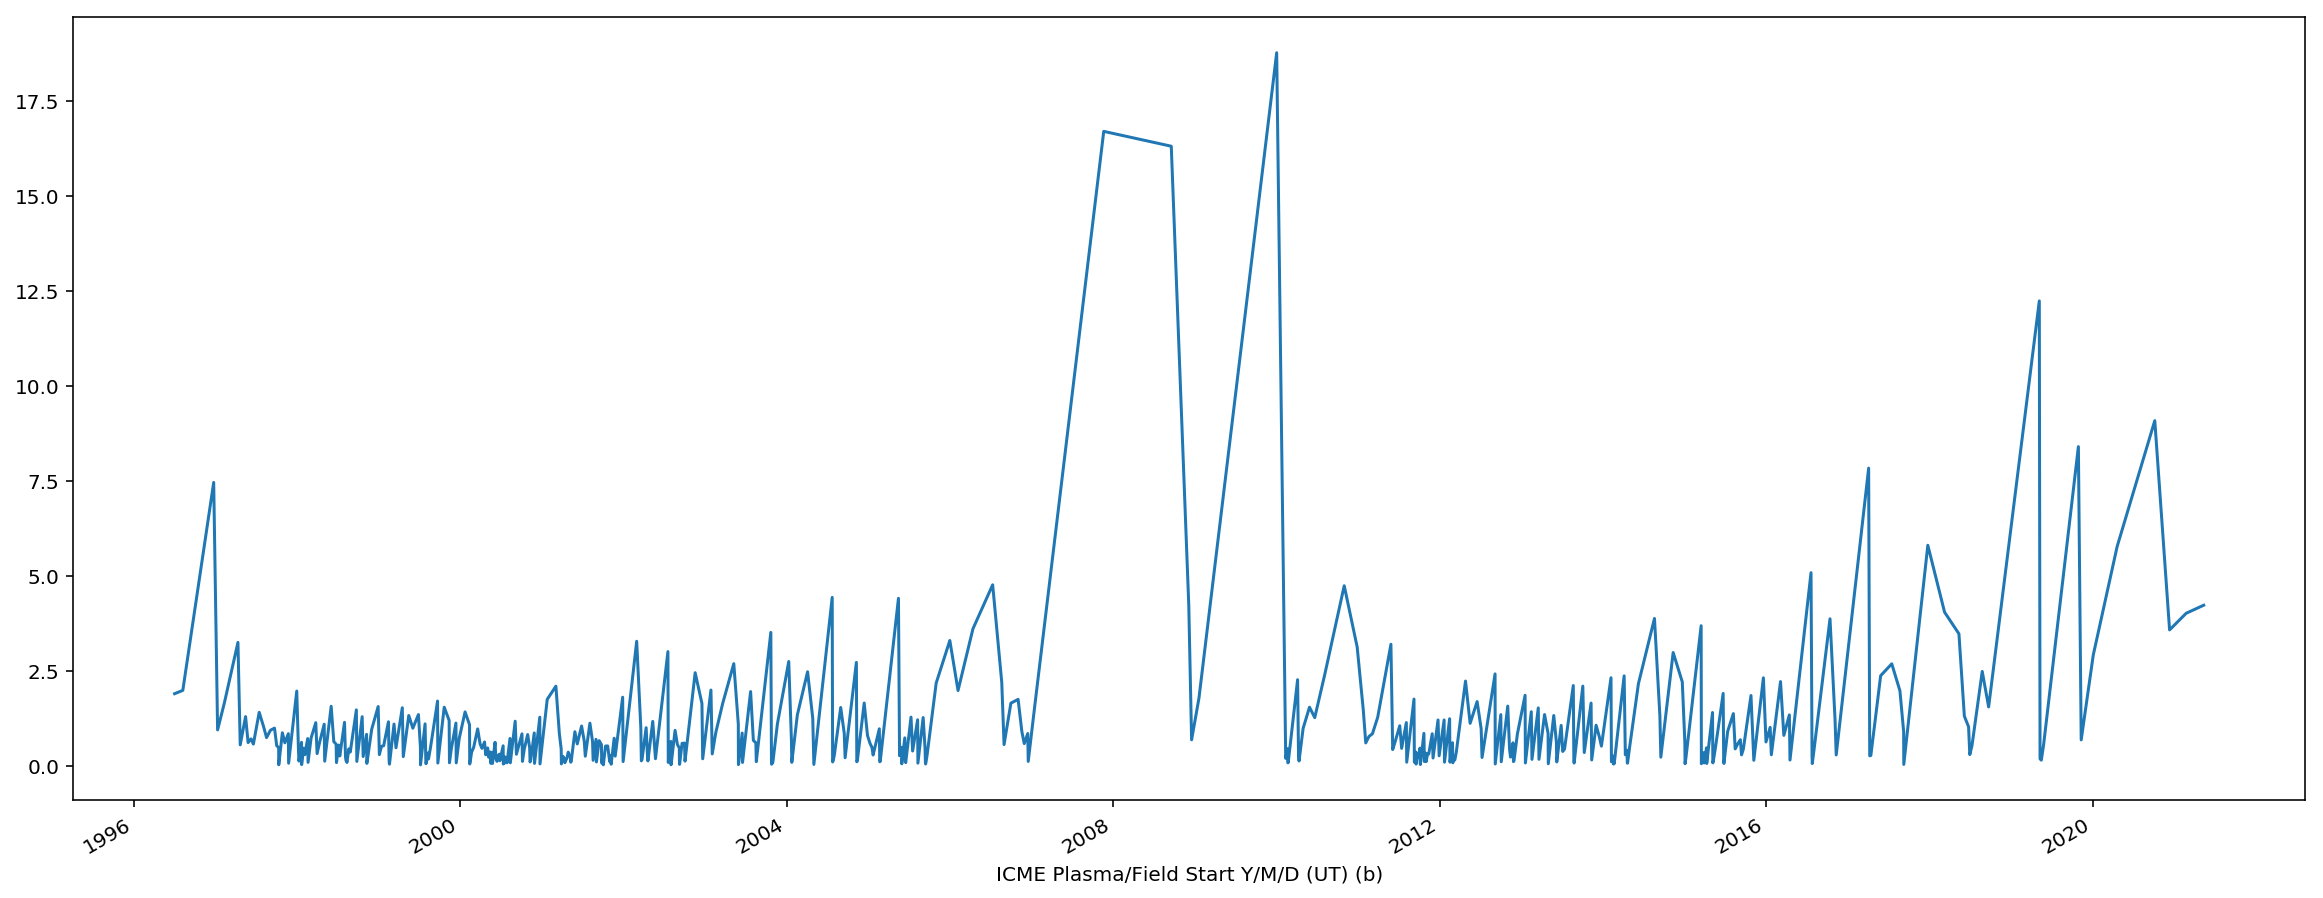

In [24]:
plt.figure(figsize=(20,8))
# plt.hlines(mean_val, 0, 2000)
time_interval_diff_norm.plot()
# plt.bar(time_interval_diff_norm)

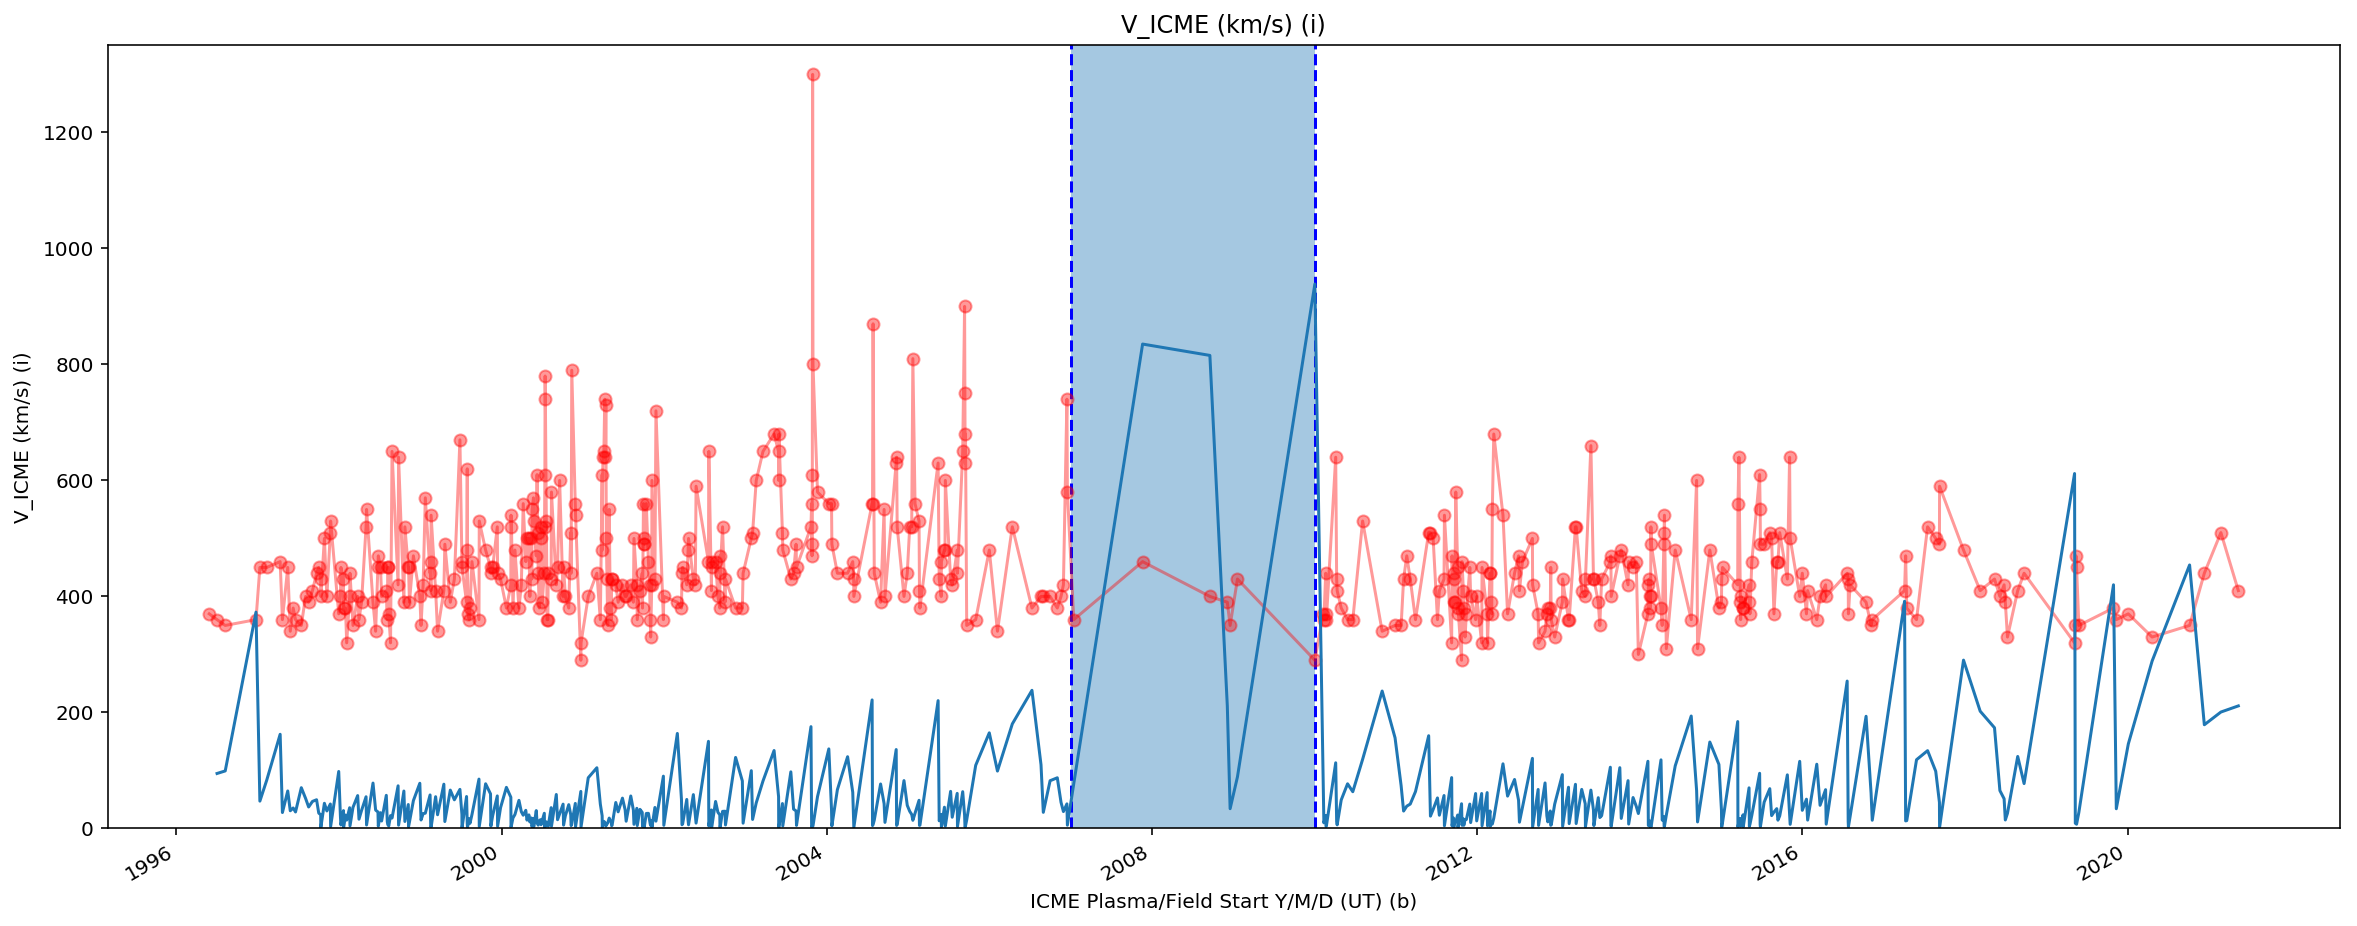

In [25]:
plt.figure(figsize=(20,8))
ICME_speed.plot(style="ro-", alpha=0.4)


plt.title("V_ICME (km/s) (i)")
plt.ylabel("V_ICME (km/s) (i)")
plt.ylim(0,)


plt.vlines('2007', 0, 1400, colors='b', linestyles='--')
plt.vlines('2010', 0, 1400, colors='b', linestyles='--')



time_interval_diff_norm2 = 50*time_interval_diff_norm
time_interval_diff_norm2.plot()


x = ['2007', '2007', '2010', '2010']
y = [0, 1400, 1400, 0]

plt.fill_between(x, y, alpha=0.4)


plt.savefig("../Figures/" + section_fig_main_title +"ICME_speed2.png")

plt.show()

time stamped and irregularly spaced and there is a gap between 2007 to 2010 where there is lack of recorded data.

## evenly spaced distributed data

the mean space of data is 18. let's resample data using the pad method and 18 days time interval.

In [26]:
ICME_speed_transformed_18D = ICME_speed.resample('18D').pad()

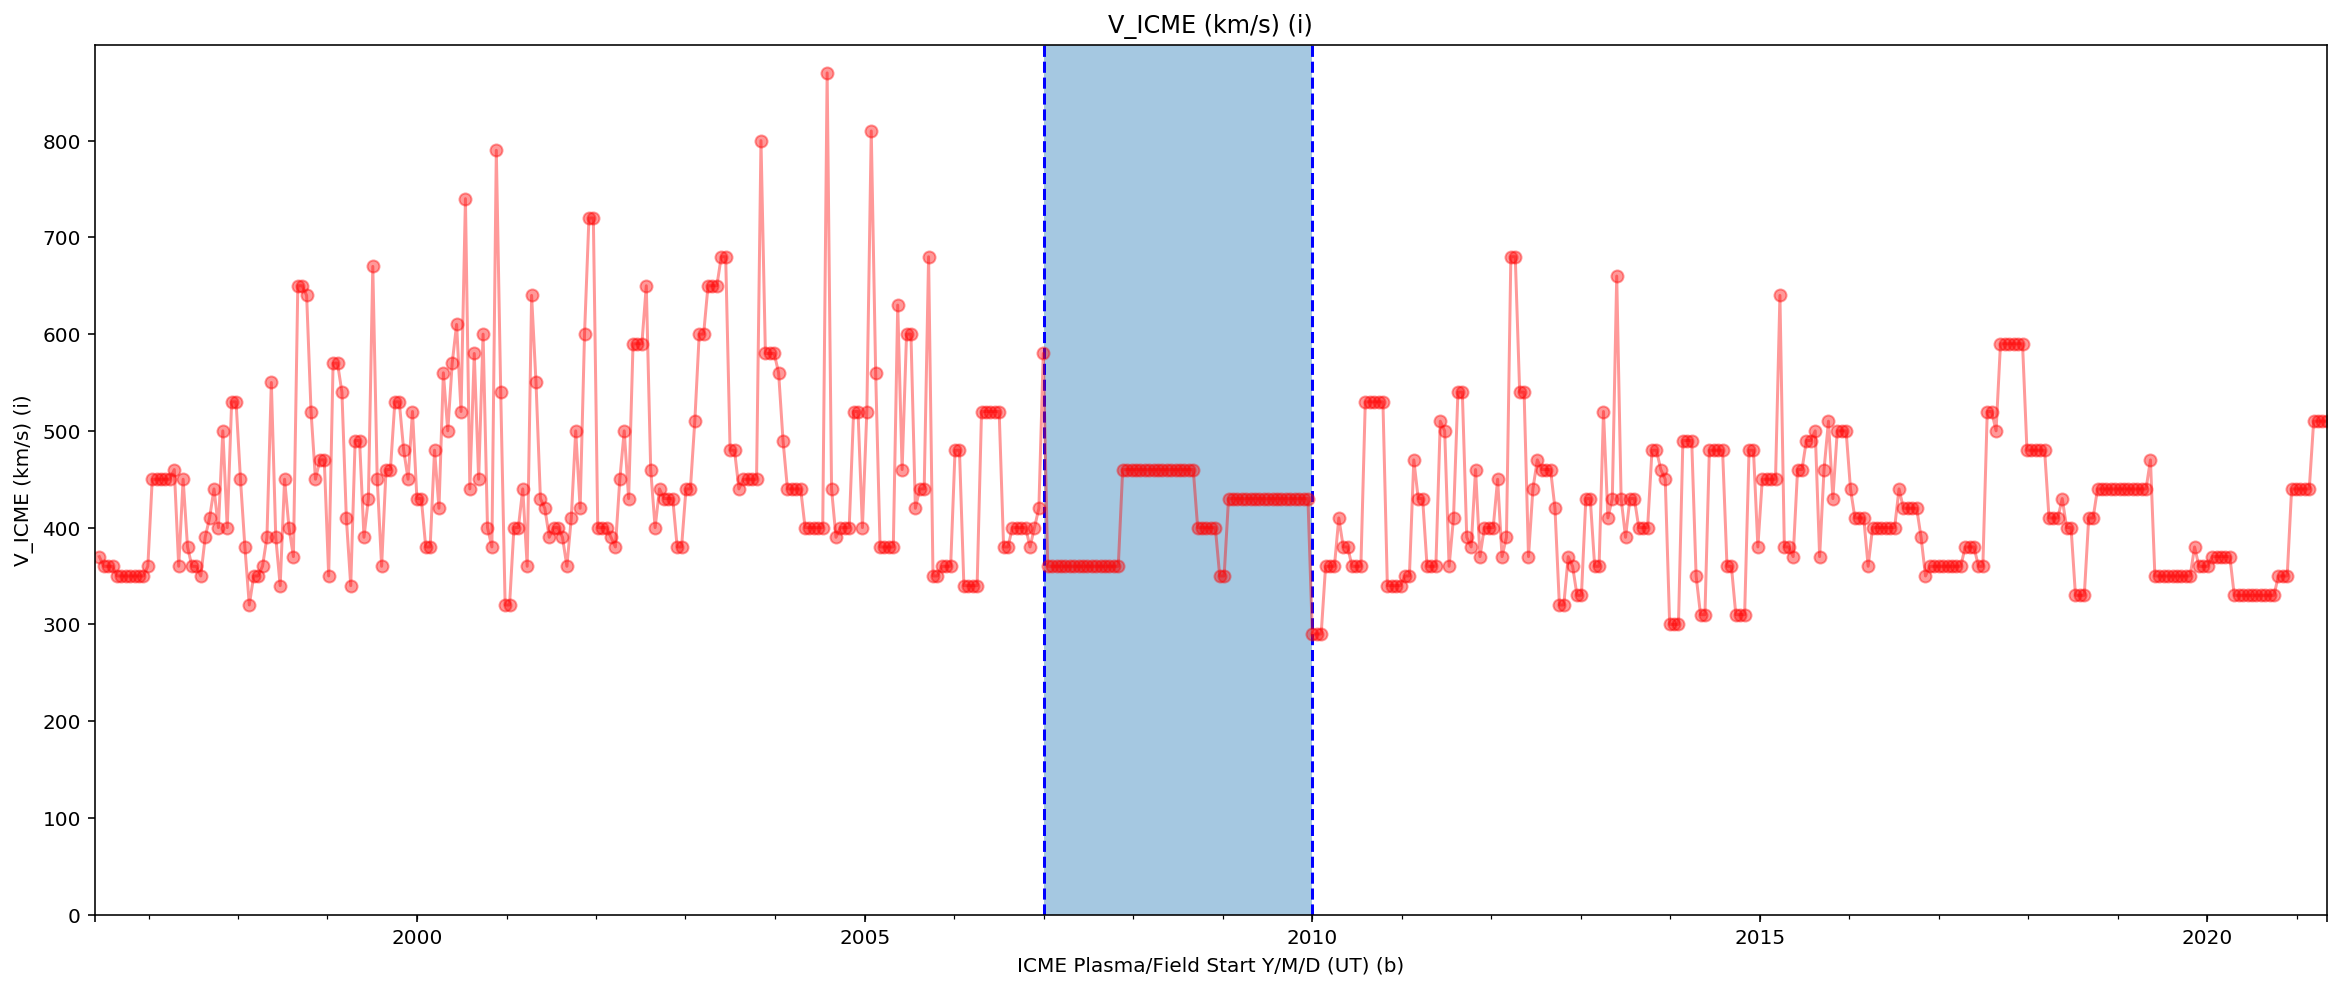

In [27]:
plt.figure(figsize=(20,8))
ICME_speed_transformed_18D.plot(style="ro-", alpha=0.4)


plt.title("V_ICME (km/s) (i)")
plt.ylabel("V_ICME (km/s) (i)")
plt.ylim(0,)


plt.vlines('2007', 0, 1400, colors='b', linestyles='--')
plt.vlines('2010', 0, 1400, colors='b', linestyles='--')


x = ['2007', '2007', '2010', '2010']
y = [0, 1400, 1400, 0]

plt.fill_between(x, y, alpha=0.4)



# plt.savefig("../Figures/" + section_fig_main_title +"ICME_speed.png")

plt.show()

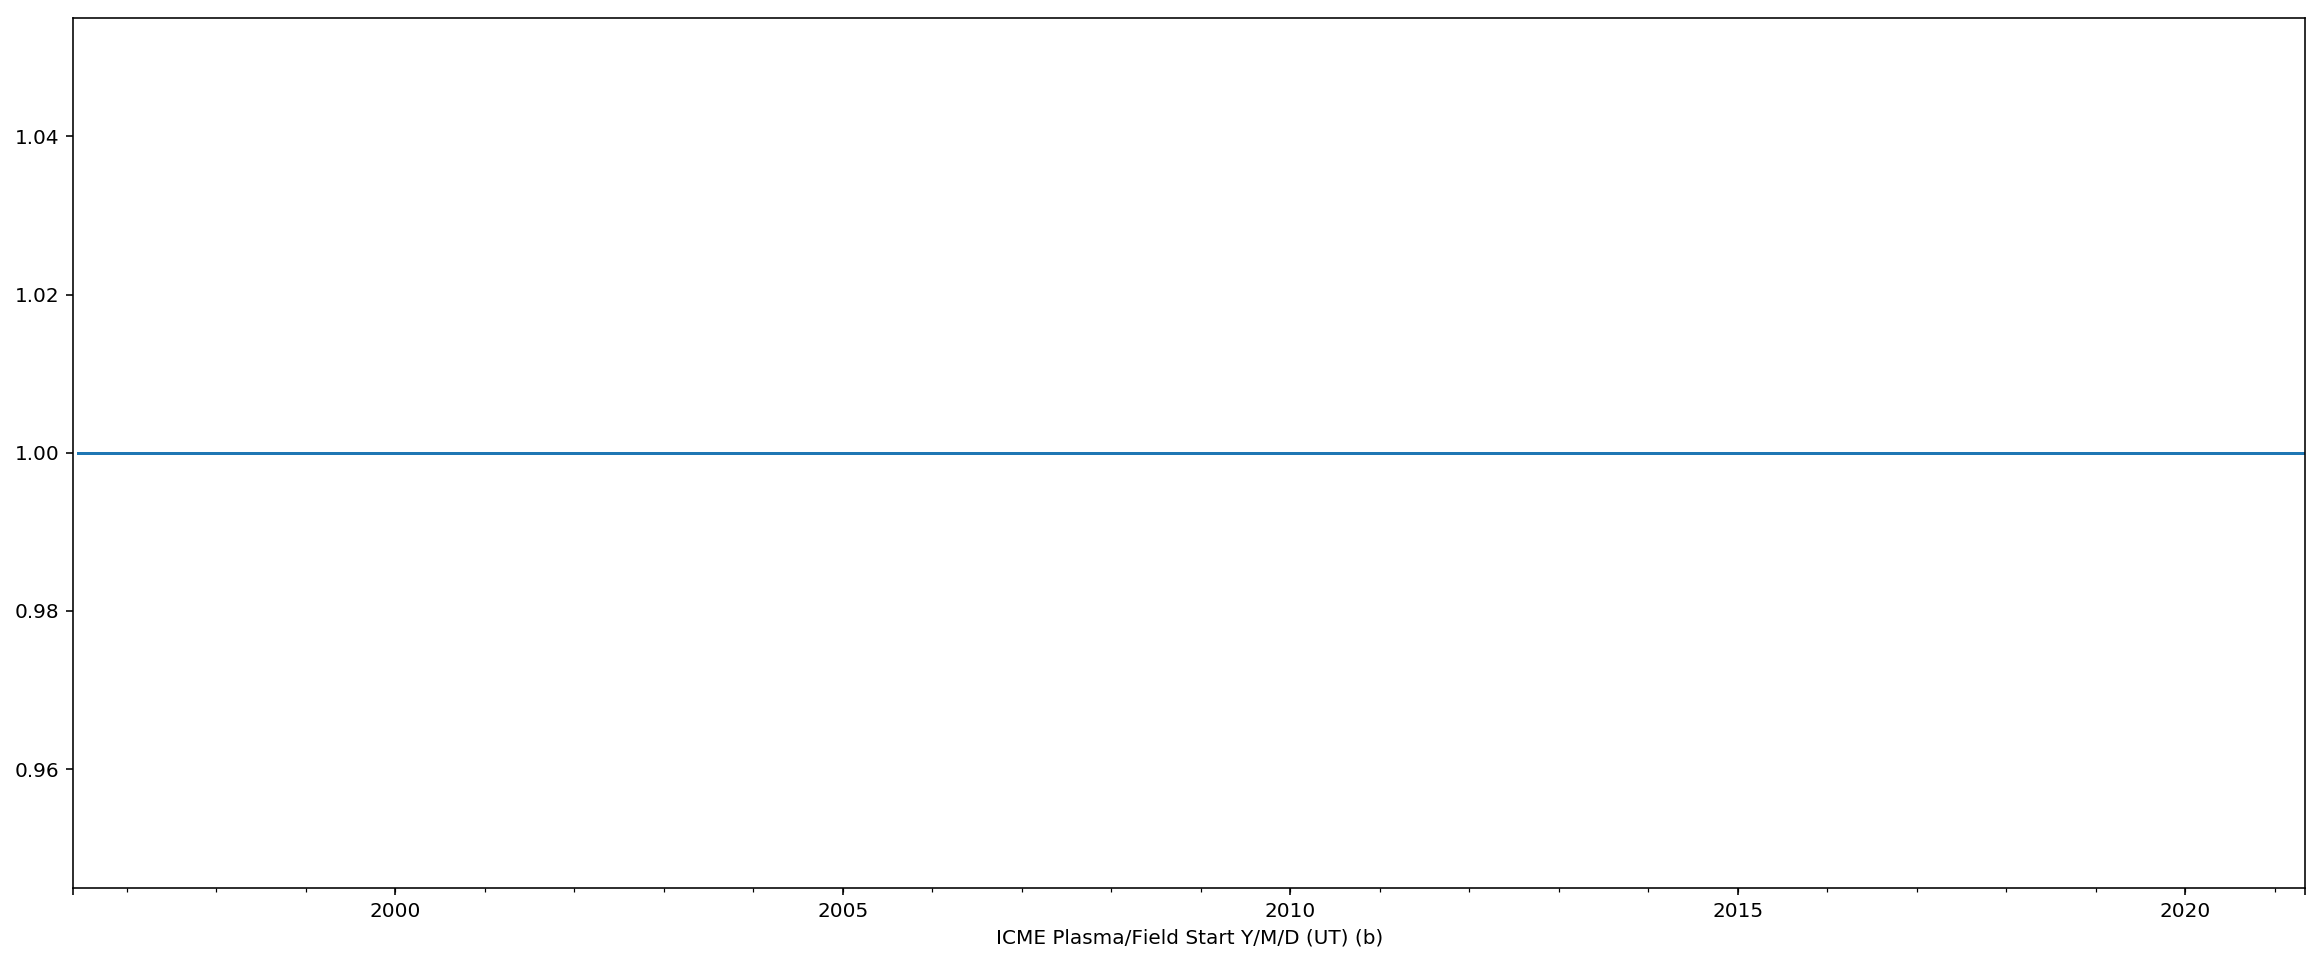

In [28]:
time_interval_diff = ICME_speed_transformed_18D.index.to_series().diff()


mean_val = np.mean(time_interval_diff)
mean_val

time_interval_diff_norm = time_interval_diff/mean_val
time_interval_diff_norm[1]


plt.figure(figsize=(20,8))
# plt.hlines(mean_val, 0, 2000)
time_interval_diff_norm.plot()
# plt.bar(time_interval_diff_norm)

In [29]:
# delete first Nan value
ICME_speed_transformed_18D = ICME_speed_transformed_18D[1:]
# save the data set
file_path = "../Data/"
file_name = "Data_ICME_speed_transformed_18D_P03_01"
ICME_speed_transformed_18D.to_pickle(file_path+file_name)

Applying any short term forcasting methods such as AR, ARIMA, or short term forcast LSTM will results in models which would be able to predict the ICME speed for 18 days ahead! 

Let's apply some models and see how close we can get for predicting the ICME speed 18 days ahead.

## ARIMA

I choose the ARIMA model which combines three methods including autoregressive, moving average, and integration.

### Searching for order of ARIMA model 

ARIMA model is composed of three parts including autoregressive, moving average, and integrated. auto regressive means the model considers the relationship between an obervation and some lagged observations (history). The integrated part use difference (subtraction) method to make data stationary. Moving average part, first applies a moving average on lagged observationas, second it calculates the difference between the moving average model and the residuals and, finally uses a relationship between an obervation and residuals (predicted by moving average model).

The ARIMA model has three hyper-parameters (p,d,q) which are repersentative for number of lagged observation to be used in autoregressive (so called laged order)(p), the number of times the observations are differenced (d), and the size of moving average window (q).

If the order of p,q are 5, that means the model used last 5 observation to predict the future time-stamps.

ARMA model is used for stationary data, while if the data is not stationary, the ARIMA comes to play.

In [30]:
import sys
print(sys.executable)


/Users/amin/anaconda3/bin/python


In [31]:
from pmdarima import auto_arima

In [32]:
len(ICME_speed_transformed_18D)

506

In [33]:
350/507

0.6903353057199211

### Training Auto ARIMA

In [34]:
# source https://machinelearningmastery.com/time-series-data-stationary-python/
X = ICME_speed_transformed_18D

split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=454.664032, mean2=416.719368
variance1=10136.890646, variance2=5250.702679


In [35]:
start = 1 # impute the first row which is nan
end = 350

training_df = ICME_speed_transformed_18D[start:end]

In [36]:
arima_model_fit = auto_arima(training_df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4081.838, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4185.519, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4157.749, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4126.249, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4183.519, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4083.211, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4083.233, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4083.810, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4083.805, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4081.291, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4085.934, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4133.222, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4079.326, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4124.261, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]          

In [37]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  349
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2036.663
Date:                Fri, 29 Oct 2021   AIC                           4079.326
Time:                        22:22:44   BIC                           4090.883
Sample:                             0   HQIC                          4083.927
                                - 349                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4073      0.047      8.683      0.000       0.315       0.499
ma.L1         -0.9626      0.018    -53.244      0.000      -0.998      -0.927
sigma2      7057.6169    354.607     19.903      0.000    6362.600    7752.633
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               283.86
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Test ARIMA model (1,1,1)

In [38]:
(len(ICME_speed_transformed_18D) - len(training_df))*18

2826

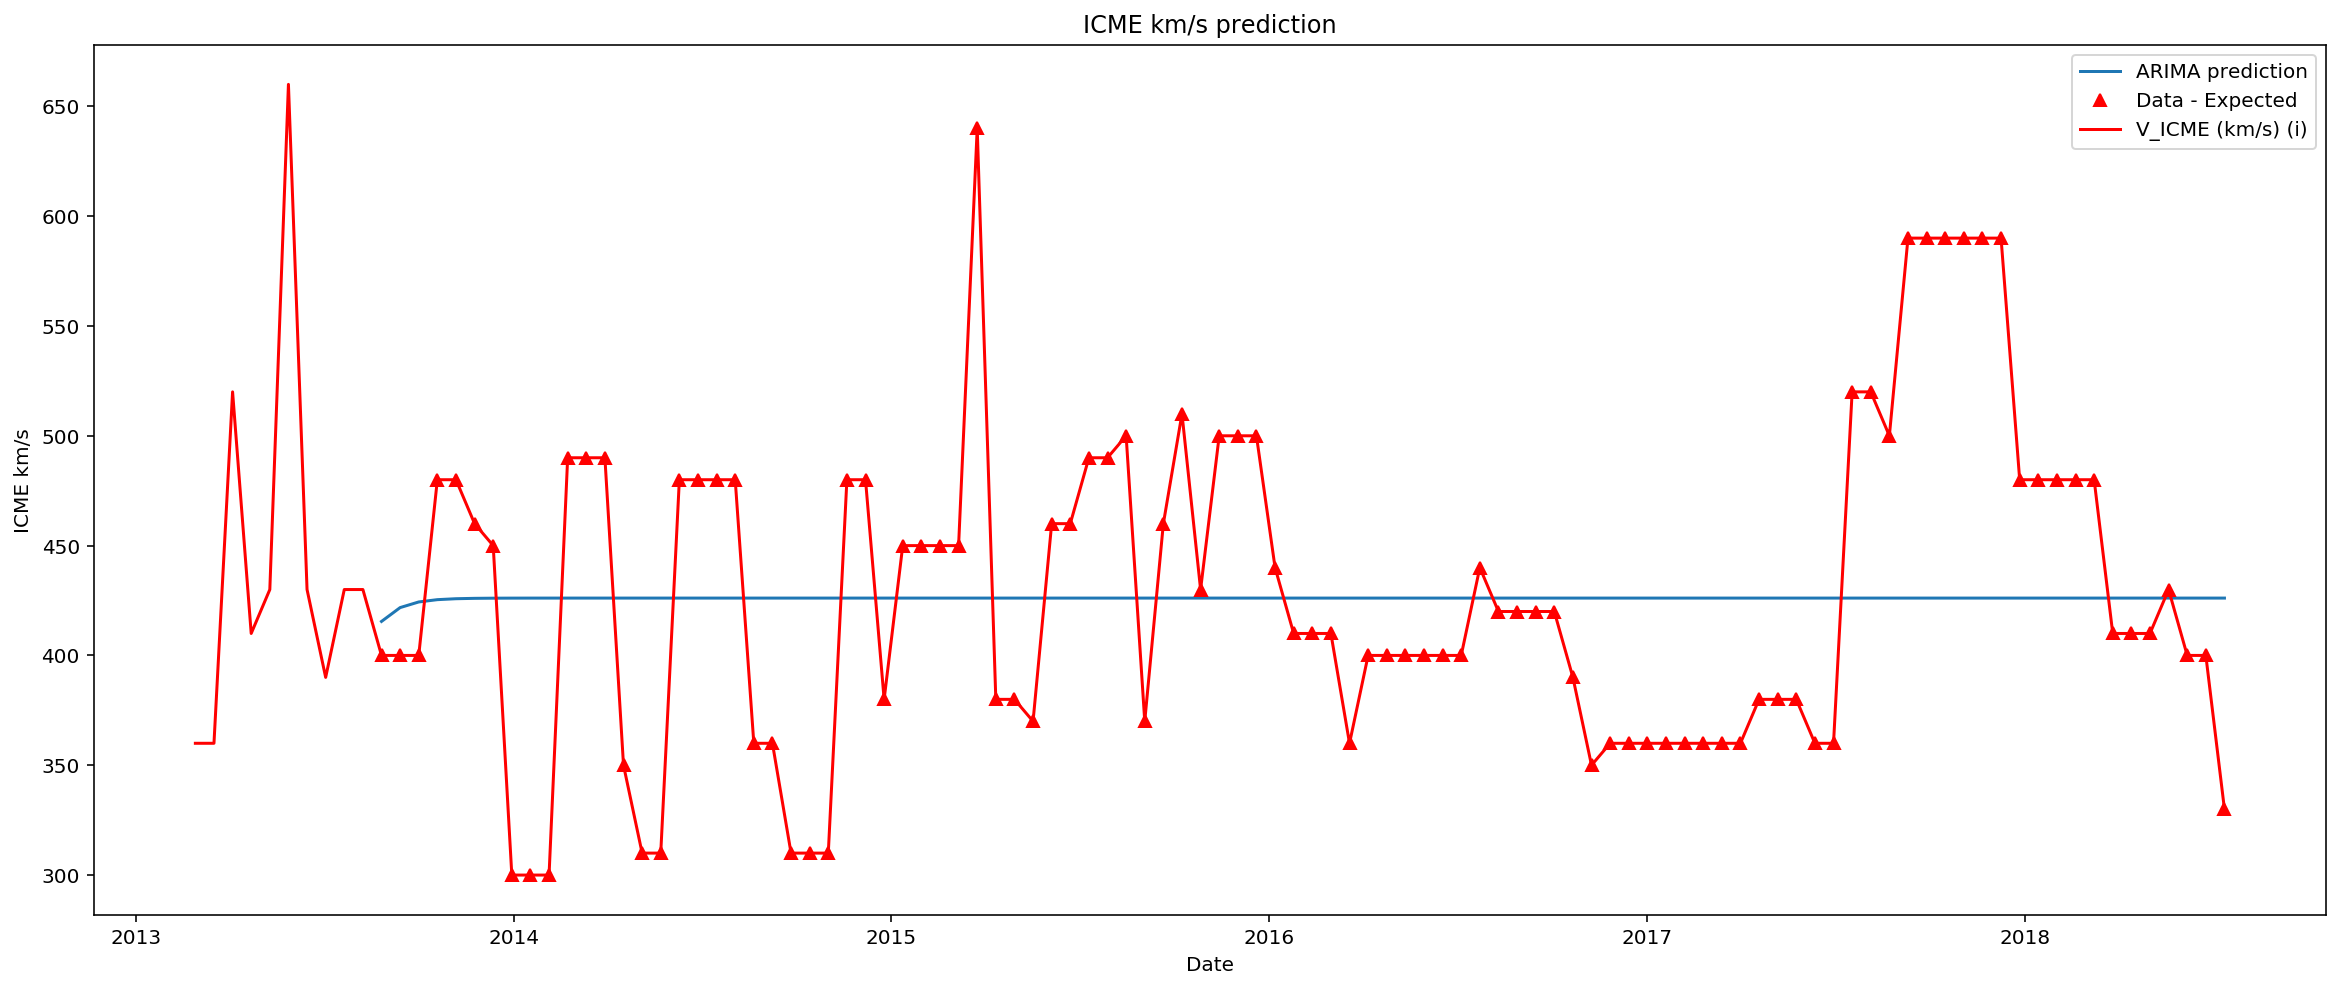

In [40]:
start = len(training_df)
ahead = 100
end = start + ahead

past = 10


expected = ICME_speed_transformed_18D[start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = ICME_speed_transformed_18D[start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')



plt.plot(ICME_speed_transformed_18D[start-past:end], c='r')


plt.xlabel('Date')
plt.ylabel('ICME km/s')
plt.title("ICME km/s prediction")


star = ICME_speed_transformed_18D[start:start+1].index
# plt.axvline(star,color='k', linestyle='--', label='test_line')
# plt.ylim(0,)

plt.legend()

# plt.show()

plt.savefig("../Figures/" + section_fig_main_title + f"ARIMA_Test_{ahead}_ahead.png")

well. not impressive results so far.

### ARIMA (5,1,0)

In [41]:
# from pandas.util._decorators import Appender

In [42]:
# !pip3 install git+https://github.com/statsmodels/statsmodels.git

In [43]:
from statsmodels.tsa.arima.model import ARIMA

In [44]:
from math import sqrt
from tqdm import tqdm

In [53]:
a = list()
a

[]

In [45]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

X = ICME_speed_transformed_18D

size = int(len(X) * 0.69) # same fraction which used for auto arima model .69
train, test = X[1:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))


100%|██████████| 157/157 [00:14<00:00, 10.72it/s]


In [46]:
r2_score(test, predictions)

0.47518556166324466

In [47]:
r2_score(test, predictions)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 50.824


### save the ARIMA 510 r2 and rmse

In [60]:
arima_510_P03_01_performance = {'R_sq': r2_score(test, predictions),
                                'rmse': sqrt(mean_squared_error(test, predictions))}

# https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type
with open("../Data/arima_510_P03_01_performance.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(arima_510_P03_01_performance, f, indent=2)

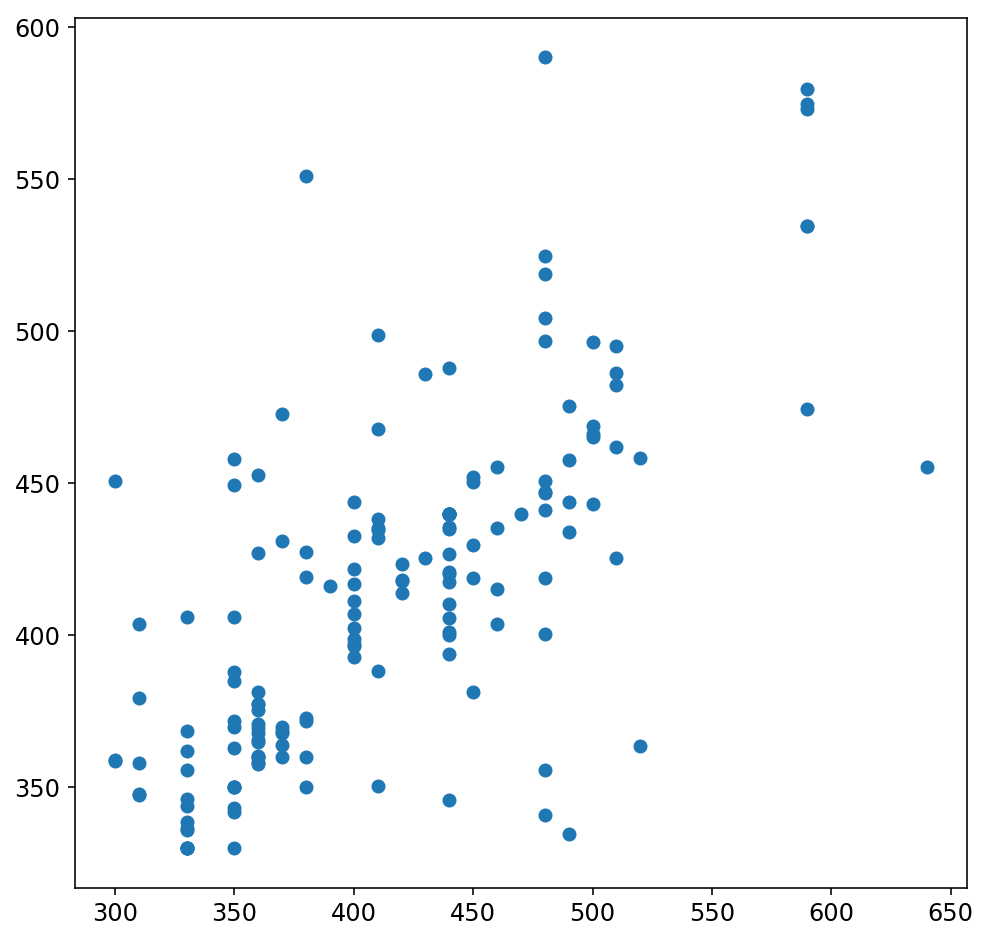

In [61]:
plt.rcParams["font.size"] = "12"

# plot forecasts against actual outcomes
plt.scatter(test,predictions)
plt.show()

In [62]:
predictions = pd.Series(predictions)
predictions.index = test.index

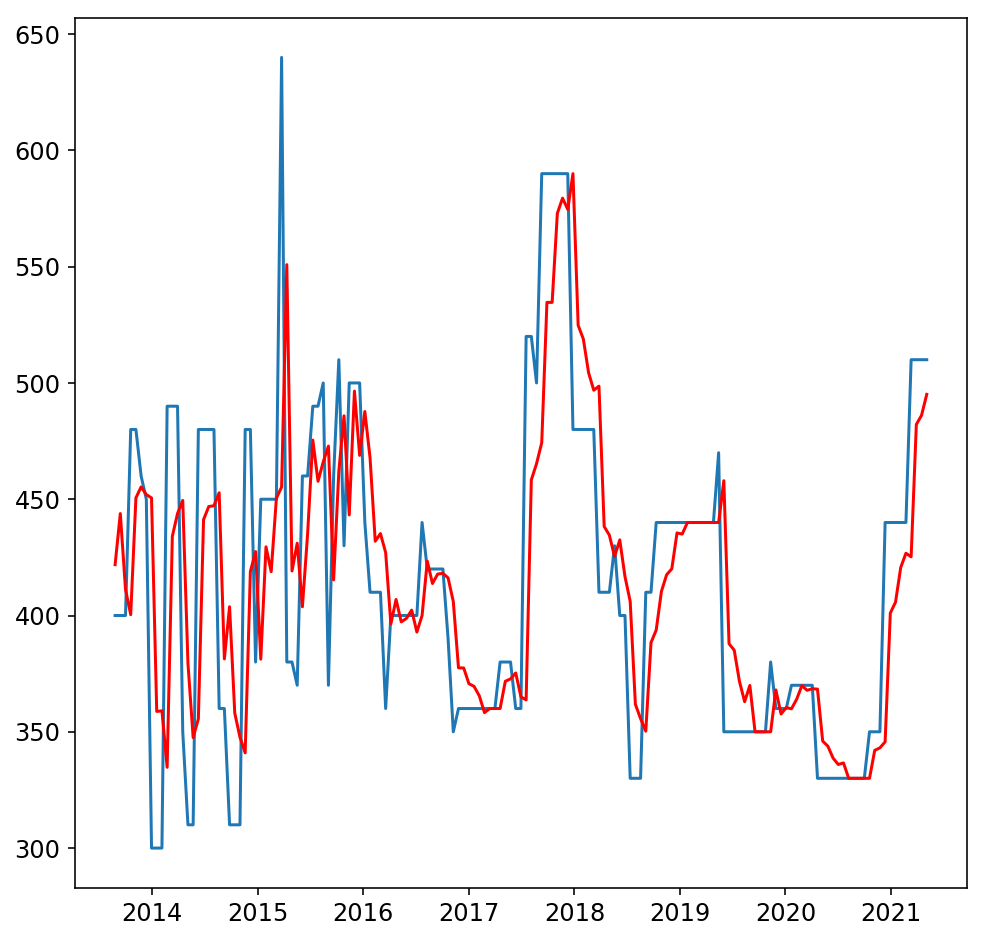

In [63]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

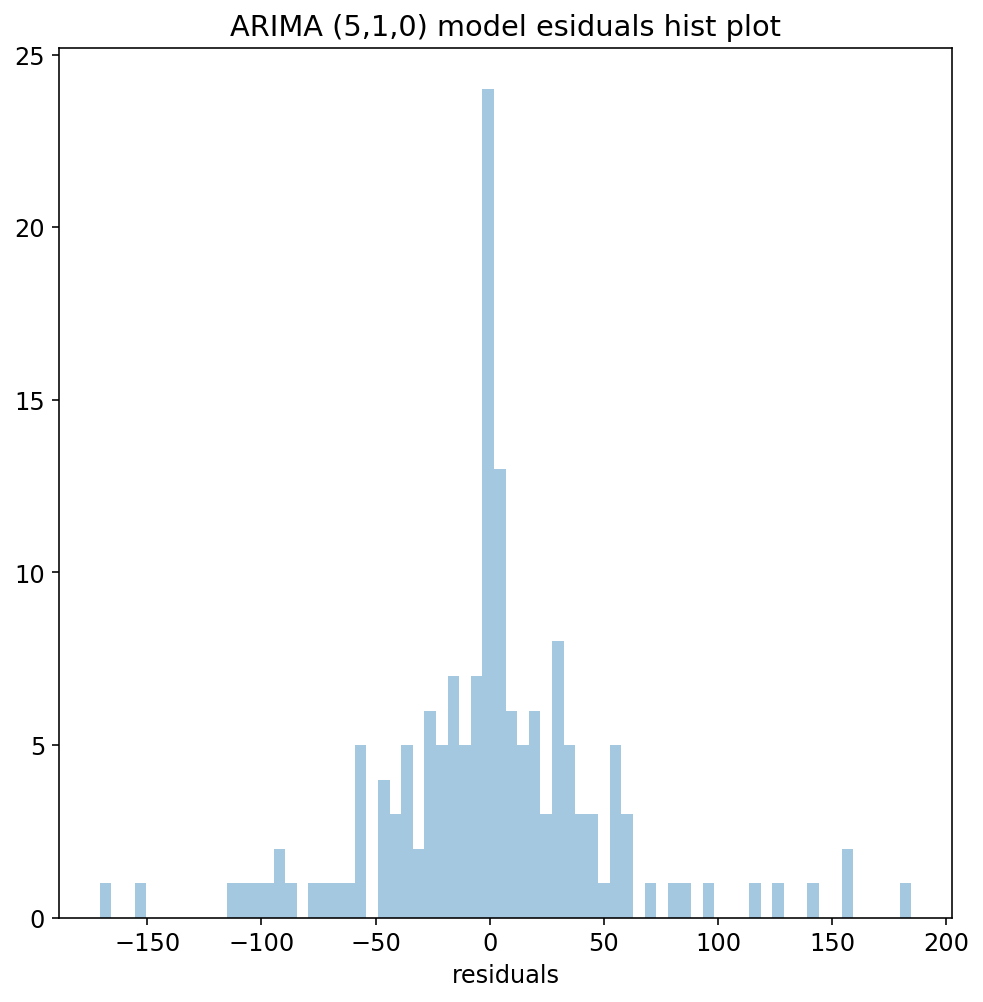

In [51]:
y = test
y_pred = predictions
# Creat residuals
resids = y - y_pred
# N assumption:
plt.hist(resids, bins=70, alpha=0.4);
plt.xlabel("residuals")
# plt.ylabel("count")
plt.title("ARIMA (5,1,0) model esiduals hist plot")
plt.savefig("../Figures/" + section_fig_main_title +"ARIMA510_residu_hist.png")

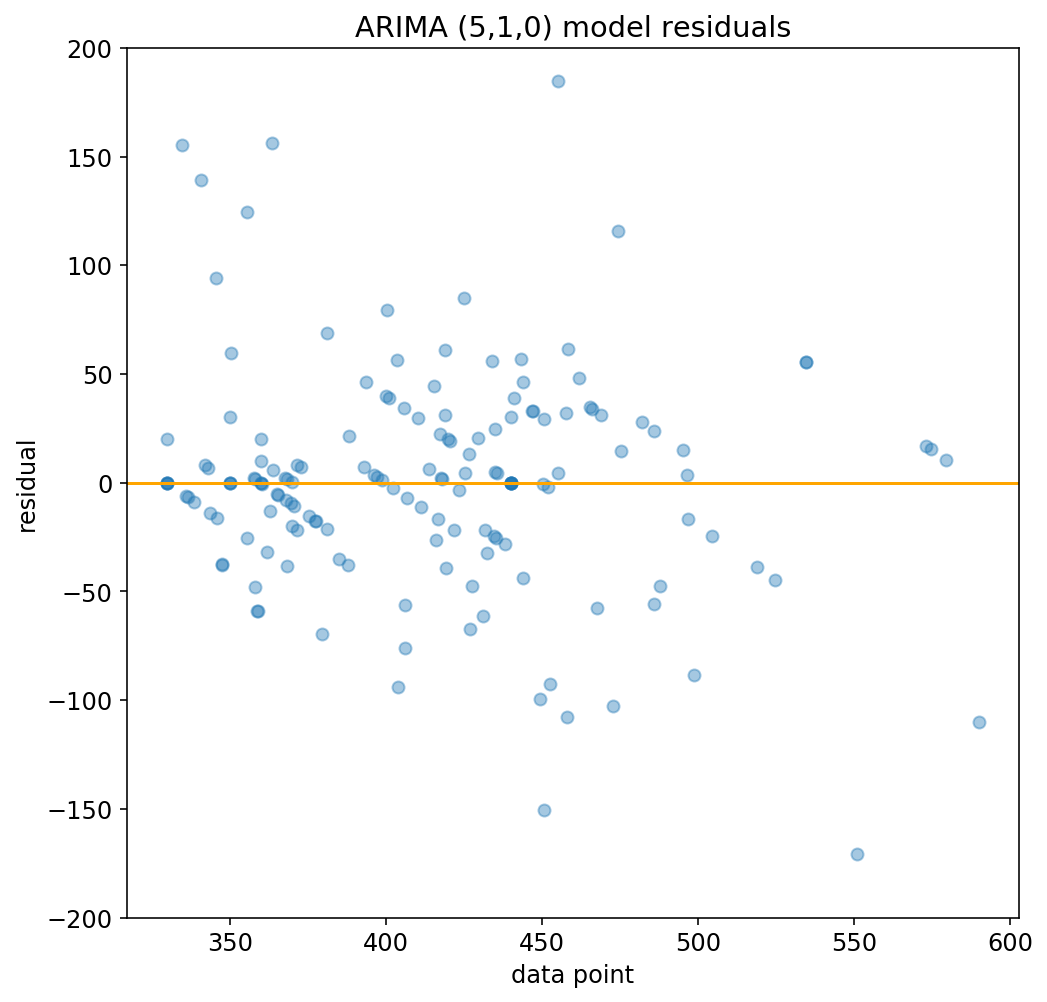

In [52]:

plt.scatter(y_pred, resids, alpha=0.4)
plt.axhline(0, color='orange');
plt.xlabel("data point")
plt.ylabel("residual")
# plt.xlim(0,)
plt.ylim(-200,200)
plt.title("ARIMA (5,1,0) model residuals")
plt.savefig("../Figures/" + section_fig_main_title +"ARIMA510_residu.png")

In [ ]:
@gif.frame
def plott(past, ahead):
    
    start = len(train)
#     ahead = len(train) + ahead # len(ICME_speed_transformed_18D)
    end = start + ahead

    past = past


    plt.figure(figsize=(20,8))
    
#     plt.plot(ICME_speed_transformed_18D[start], 
#              predictions[0], c='b')
    
    plt.plot(predictions[0:ahead], label='ARIMA prediction')
    plt.plot(test[0:ahead], 'r^', label='Data - Expected')



    plt.plot(ICME_speed_transformed_18D[start-past:start+ahead], c='r')


    plt.xlabel('Date')
    plt.ylabel('ICME km/s')
    plt.title("ICME km/s prediction")


    star = ICME_speed_transformed_18D[start:start+1].index
    plt.vlines(star, 0, 700, color='k', linestyle='--', label='History')
    plt.ylim(200,)

    plt.legend()


In [ ]:
plott(100, 20)

### GIF vis

In [ ]:
len(test)

In [ ]:
frames = []    
for i in tqdm(range(1,len(test))):

    
    frame = plott(past=100, ahead = i)
    frames.append(frame)

In [ ]:
gif.save(frames, "../Figures/ARIMA510_GIF.gif", duration=2)

## AR model

In [64]:
# # train autoregression
# model = AutoReg(train, lags=150)
# ar_model_fit = model.fit()
# # print('Coefficients: %s' % ar_model_fit.params)

In [65]:
# # make predictions
# predictions = ar_model_fit.predict(start=len(train), 
#                                 end=len(train)+len(test)-1, 
#                                 dynamic=False)

# # apply same index for prediction df
# predictions.index = test.index

In [66]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

X = ICME_speed_transformed_18D

size = int(len(X) * 0.69) # same fraction which used for auto arima model .69
train, test = X[1:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in tqdm(range(len(test))):
    
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit()

#     lag = len(history)
#     print(lag)
    model = AutoReg(history, lags=150)
    model_fit = model.fit()
    
    
    
    
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))


100%|██████████| 157/157 [00:01<00:00, 94.79it/s]


In [67]:
from sklearn.metrics import r2_score
r2_score(test, predictions)

-0.4876640652901383

In [68]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 85.569


In [69]:
ar_150lgs_P03_01_performance = {'R_sq': r2_score(test, predictions),
                                'rmse': sqrt(mean_squared_error(test, predictions))}

# https://stackoverflow.com/questions/27745500/how-to-save-a-list-to-a-file-and-read-it-as-a-list-type
with open("../Data/ar_150lgs_P03_01_performance.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(ar_150lgs_P03_01_performance, f, indent=2)

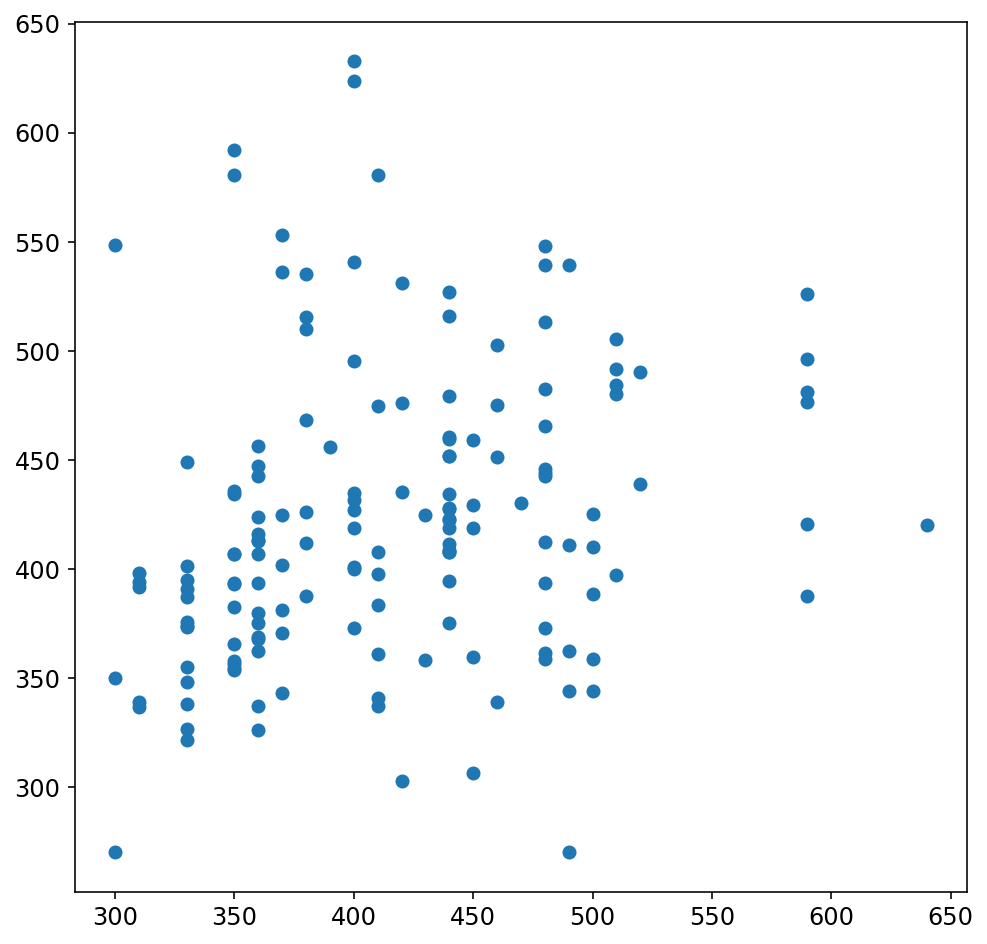

In [70]:
plt.rcParams["font.size"] = "12"

# plot forecasts against actual outcomes
plt.scatter(test,predictions)
plt.show()

In [71]:
predictions = pd.Series(predictions)
predictions.index = test.index

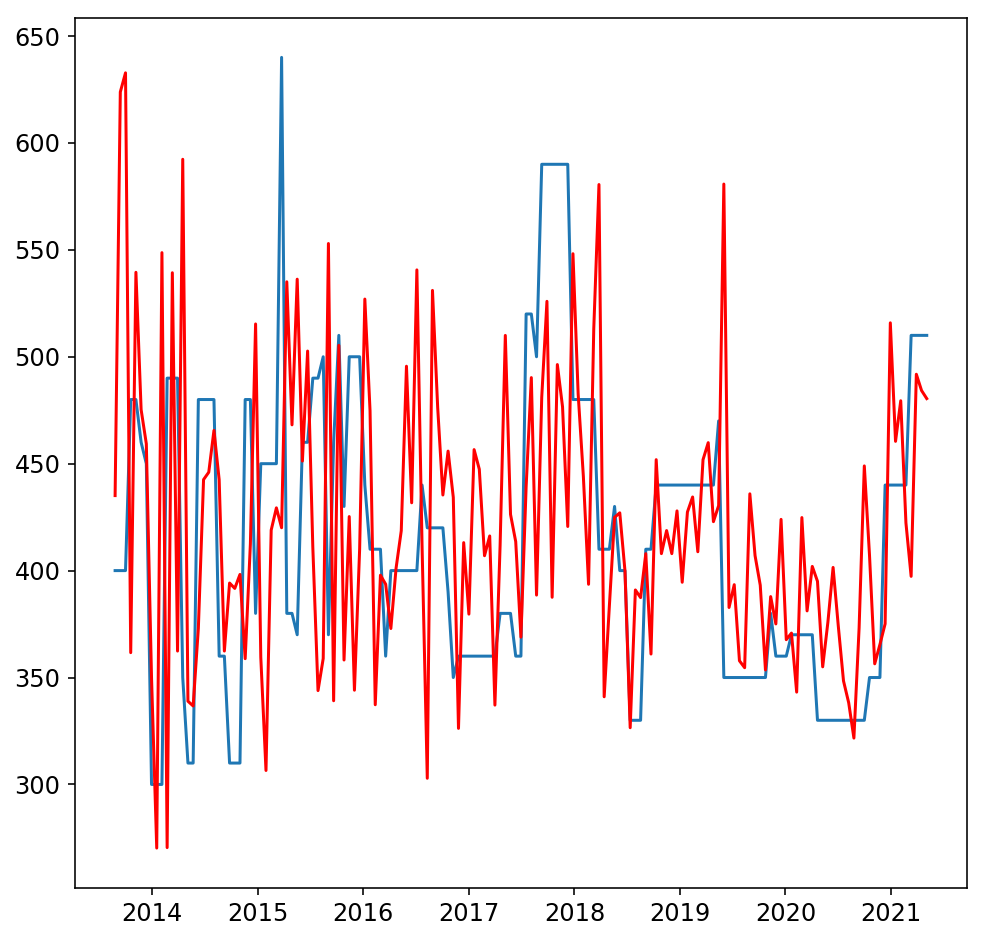

In [72]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
@gif.frame
def plott(past, ahead):
    
    start = len(train)
#     ahead = len(train) + ahead # len(ICME_speed_transformed_18D)
    end = start + ahead

    past = past


    plt.figure(figsize=(20,8))
#     plt.subplot(2,1,1)
#     plt.plot(ICME_speed_transformed_18D[start], 
#              predictions[0], c='b')
    
    plt.plot(predictions[0:ahead], label='AR_150_lags prediction')
    plt.plot(test[0:ahead], 'r^', label='Data - Expected')



    plt.plot(ICME_speed_transformed_18D[start-past:start+ahead], c='r')


    plt.xlabel('Date')
    plt.ylabel('ICME km/s')
    plt.title("ICME km/s prediction")


    star = ICME_speed_transformed_18D[start:start+1].index
    plt.vlines(star, 0, 700, color='k', linestyle='--', label='History')
    plt.ylim(200,)

    
#     plt.subplot(2,1,2)
    
#     plt.scatter(test, predictions)
#     plt.show()
    
    
    
    
    
    
    
    
    plt.legend()


In [ ]:
plott(100, 20)

## GIF

In [ ]:
frames = []    
for i in tqdm(range(1,len(test))):

    
    frame = plott(past=100, ahead = i)
    frames.append(frame)

In [ ]:
gif.save(frames, "../Figures/AR_150.gif", duration=2)